# Transaction by type Case study
*Ferran Carrascosa* 

*2022 - 06 - 27*

In [220]:
import gc
import time
import numpy as np
import pandas as pd
import lightgbm as lgb
import os


In [2]:
# metricas

def RMSE_func(real, estim):
    return np.sqrt(np.mean((real - estim)*(real - estim)))

def MQ_func(real, estim,q):
    return np.mean(np.where(real>=estim,q*(real - estim),(1-q)*(estim - real)))

def PQ_func(real, estim,q):
    return np.mean(np.where(real>=estim,1,0))




In [3]:
data = pd.read_pickle("../../data/output/transaction/panel_data2.pkl", compression='zip' )
data.shape

(1750000, 22)

panel data:

- time variable es "yearmonth" codified with autonumeric
- user ideintificator is "user_id"
- type of transaction is "transac_code"
- days: number of days of the month

The type of transaction is codified as:

- "transac_code","explanation","direction"
- 1, "ATM","Out"
- 2, "Groceries","Out"
- 3, "Gastronomie","Out"
- 4, "Shopping/(Fashion)","Out"
- 5, "Home and DIY, House Energy","Out"
- 6, "Travel/Hotel","Out"
- 7, "Transport","Out"
- 8, "Automotive/Gas","Out"
- 9, "Family/Babies/Children","Out"
- 10,"Entertainment/Leisure","Out"
- 11,"Drugstore","Out"
- 12,"Finance","Out"
- 13,"Insurance","Out"
- 14,"Taxes and Fines","Out"
- 15,"Education","Out"
- 16,"Miscellaneous","Out"
- 17,"Business Expenses","Out"
- 18,"Direct Debit","Out"
- 19,"Debit Transfer","Out"
- 20,"MoneyBeam Transfer","Out"
- 21,"Cash withdrawal","Out"
- 22,"Transferwise Transaction","Out"
- 23,"Cash deposit","In"
- 24,"Credit Transfer","In"
- 25,"Debit Reversal","In"




Separating the train, validation and test sets to train the model with the user id:

In [4]:
data[data.amount!=0].yearmonth.value_counts()

7    31207
5    31205
6    30589
3    30199
4    30169
2    27699
Name: yearmonth, dtype: int64

In [4]:
X_train = data[(data.yearmonth < 7)&(data.yearmonth > 4)].drop(['amount'], axis=1)
Y_train = data[(data.yearmonth < 7)&(data.yearmonth > 4)]['amount']
X_valid = data[data.yearmonth == 7].drop(['amount'], axis=1)
Y_valid = data[data.yearmonth == 7]['amount']
X_test = data[data.yearmonth == 8].drop(['amount'], axis=1)


1250000        1
1250001        1
1250002        1
1250003        1
1250004        1
           ...  
1499995    10000
1499996    10000
1499997    10000
1499998    10000
1499999    10000
Name: user_id, Length: 250000, dtype: int32

In [5]:
#del data
#gc.collect();

Training the mean model with user id feature:

In [7]:
data.columns

Index(['yearmonth', 'user_id', 'transac_code', 'direction_code', 'days',
       'amount', 'amount_lag_1', 'amount_lag_2', 'amount_lag_3',
       'amount_lag_4', 'amount_SectorGroup_lag_1', 'amount_SectorGroup_lag_2',
       'amount_SectorGroup_lag_3', 'amount_SectorGroup_lag_4',
       'amount_totOut_lag_1', 'amount_totOut_lag_2', 'amount_totOut_lag_3',
       'amount_totOut_lag_4', 'amount_totIn_lag_1', 'amount_totIn_lag_2',
       'amount_totIn_lag_3', 'amount_totIn_lag_4'],
      dtype='object')

In [218]:
QUANT_PARAM = 0.9
ROUNDS = 100

params = {
    'task': 'train'
    ,'boosting_type': 'gbdt'
    ,'objective': 'quantile'
    ,'metric': 'quantile'
    ,'num_leaves': 70
    ,'max_depth': 8
    ,'feature_fraction': 0.8
    ,'bagging_fraction': 0.8
    ,'bagging_freq': 5
    ,'learning_rate': 0.01
    #,'min_data_in_leaf': 300
    ,'seed': 42
    #,'early_stopping_round ': 10
    ,'alpha' : QUANT_PARAM
}


formating for lgb
light GBM train :-)


D:\griu\anaconda3\envs\gpboost_env\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13052
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 21


D:\griu\anaconda3\envs\gpboost_env\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\griu\anaconda3\envs\gpboost_env\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Time (s): 4.189502239227295


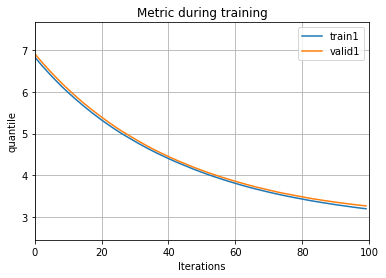

In [219]:
ts = time.time()

print('formating for lgb')
d_train = lgb.Dataset(X_train,
                      label=Y_train,
                      categorical_feature=["user_id","transac_code"])
#del df_train

d_valid = lgb.Dataset(X_valid,
                      label=Y_valid,
                      categorical_feature=["user_id","transac_code"])

d_test = lgb.Dataset(X_test,
                      categorical_feature=["user_id","transac_code"])

print('light GBM train :-)')

evals={}
bst = lgb.train(params, d_train, ROUNDS, [d_train,d_valid], ["train1","valid1"]  ,callbacks = [lgb.record_evaluation(evals)] )
#bst = lgb.train(params, d_train, ROUNDS, [d_train,d_valid], ["train1","valid1"] )
#bstCV = lgb.cv(params, d_train, ROUNDS,nfold=5)

lgb.plot_metric(evals);

print (f'Time (s):', time.time() - ts)

In [19]:
# save model
#bst.save_model('../output/model_quant.txt')
#bst = lgb.Booster(model_file='../output/model_quant.txt')  # init model


In [15]:
### build candidates list for test ###
print('light GBM predict')
preds_train = bst.predict(X_train)
preds_valid = bst.predict(X_valid)

rmse_train = RMSE_func(Y_train,preds_train)
rmse_valid = RMSE_func(Y_valid,preds_valid)

mq_train = MQ_func(Y_train,preds_train,QUANT_PARAM)
mq_valid = MQ_func(Y_valid,preds_valid,QUANT_PARAM)

pq_train = PQ_func(Y_train,preds_train,QUANT_PARAM)
pq_valid = PQ_func(Y_valid,preds_valid,QUANT_PARAM)

print(rmse_train)
print(rmse_valid)
print(mq_train)
print(mq_valid)
print(pq_train)
print(pq_valid)


light GBM predict
92.74586897792105
97.25078776624535
2.4409257014627066
2.9805745793452085
0.854882
0.854164


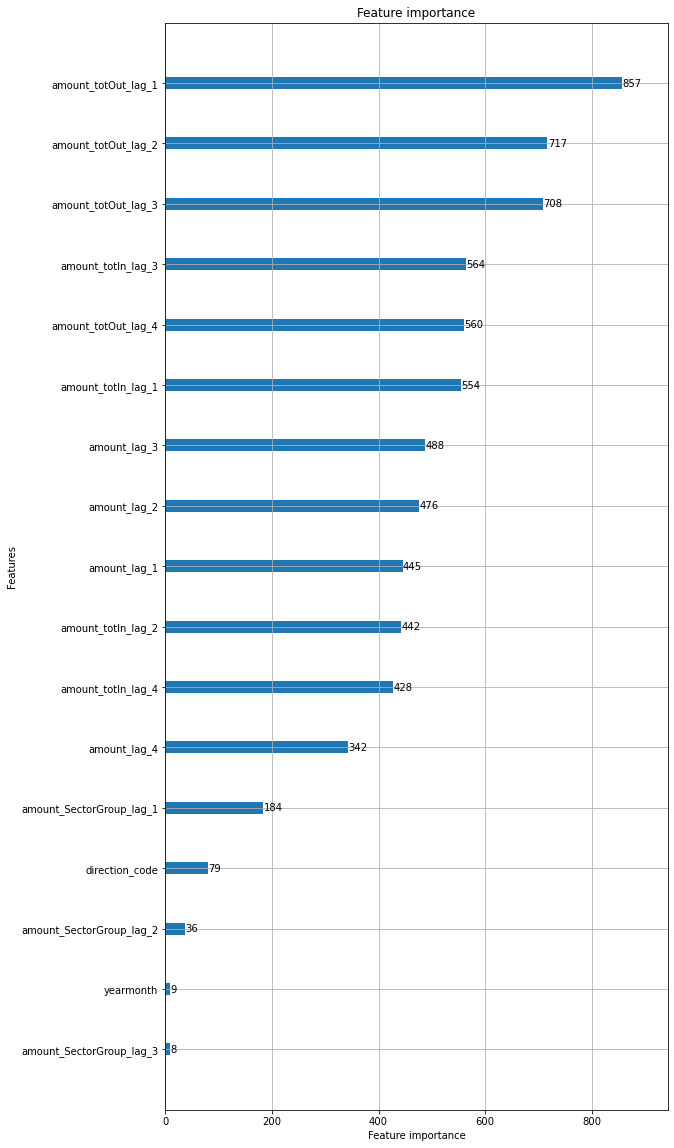

In [16]:
lgb.plot_importance(bst, figsize=(9,20));


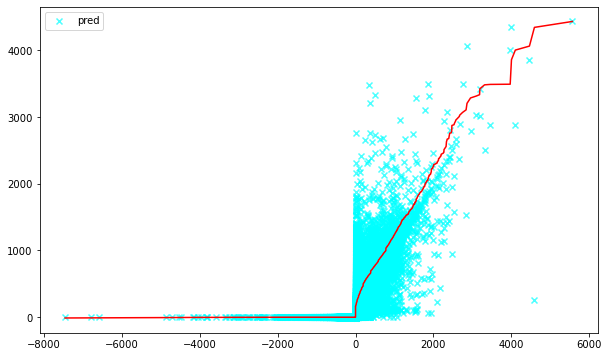

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

#plt.scatter(X_train.MedInc, lower_pred, color='limegreen', marker='o', label='lower', lw=0.5, alpha=0.5)
plt.scatter(Y_train, preds_train, color='aqua', marker='x', label='pred', alpha=0.7)
#plt.scatter(X_train.MedInc, upper_pred, color='dodgerblue', marker='o', label='upper', lw=0.5, alpha=0.5)
#plt.plot(sorted(Y_train), sorted(lower_pred), color='black')
plt.plot(sorted(Y_train), sorted(preds_train), color='red')
#plt.plot(sorted(Y_train), sorted(upper_pred), color='black')
plt.legend()

plt.show()



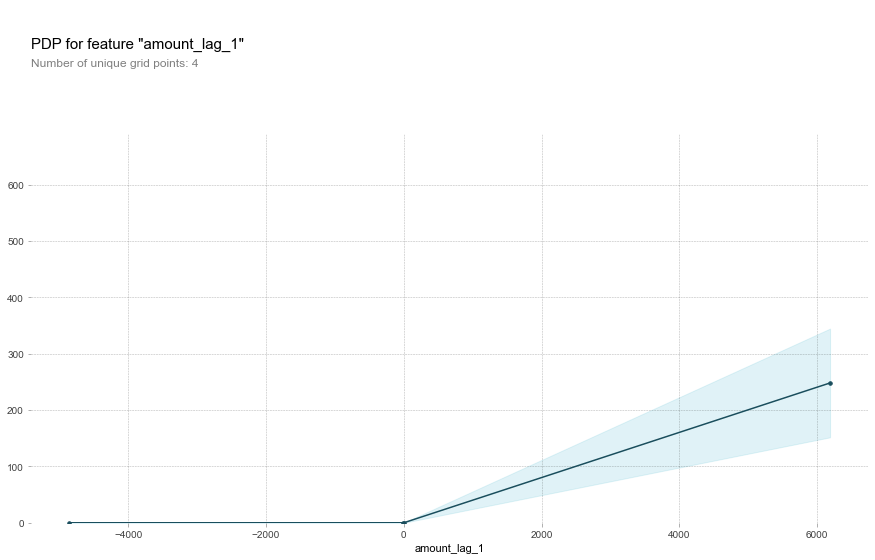

In [18]:
from pdpbox import pdp, get_dataset, info_plots
pdp_dist = pdp.pdp_isolate(model=bst, dataset=X_train
                           , model_features=X_train.columns
                           , feature='amount_lag_1',num_grid_points=15)
pdp.pdp_plot(pdp_dist, 'amount_lag_1');
X_train.columns = ["".join (c if c.isalnum() else "_" for c in str(x)) for x in X_train.columns]


In [20]:
import shap
shap.initjs()


In [ ]:
#%time shap_values = shap.TreeExplainer(lgbm).shap_values(valid_x)
#shap.summary_plot(shap_values, X_train)
#shap.dependence_plot("EXT_SOURCE_2", shap_values, valid_x)
#shap.dependence_plot("EXT_SOURCE_3", shap_values, valid_x)


#https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
# print the JS visualization code to the notebook
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])
#shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])


In [ ]:
#https://www.kaggle.com/code/cast42/lightgbm-model-explained-by-shap/notebook
#shap.summary_plot(shap_values, X)


In [ ]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values[1], X_train, display_features=X_train)


## Random effects gbm

In [221]:
gp_model = gpb.GPModel(group_data=X_train[["transac_code"]])

In [222]:
data_train = gpb.Dataset(data=X_train[[ "yearmonth",'user_id', 'direction_code', 'days',
       'amount_lag_1', 'amount_lag_2', 'amount_lag_3', 'amount_lag_4',
       'amount_SectorGroup_lag_1', 'amount_SectorGroup_lag_2',
       'amount_SectorGroup_lag_3', 'amount_SectorGroup_lag_4',
       'amount_totOut_lag_1', 'amount_totOut_lag_2', 'amount_totOut_lag_3',
       'amount_totOut_lag_4', 'amount_totIn_lag_1', 'amount_totIn_lag_2',
       'amount_totIn_lag_3', 'amount_totIn_lag_4']], label = Y_train
        ,categorical_feature=["user_id"]
                        )


In [223]:
params = { 'objective': 'regression_l2',
            'learning_rate': 0.01,
            'max_depth': 8,
            'min_data_in_leaf': 1,
            'num_leaves': 70,
            'max_depth': 8,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            #'bagging_freq': 5,
            'verbose': 0 ,
            'boosting_type': 'gbdt'
       }


In [224]:
t1 = time.process_time()

# Train GPBoost model
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=10)


t2 = time.process_time()
t2 - t1

D:\griu\anaconda3\envs\gpboost_env\lib\site-packages\gpboost\basic.py:1822: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


20.515625

In [225]:
pred = bst.predict(data=X_valid[["yearmonth", 'user_id', 'direction_code', 'days',
       'amount_lag_1', 'amount_lag_2', 'amount_lag_3', 'amount_lag_4',
       'amount_SectorGroup_lag_1', 'amount_SectorGroup_lag_2',
       'amount_SectorGroup_lag_3', 'amount_SectorGroup_lag_4',
       'amount_totOut_lag_1', 'amount_totOut_lag_2', 'amount_totOut_lag_3',
       'amount_totOut_lag_4', 'amount_totIn_lag_1', 'amount_totIn_lag_2',
       'amount_totIn_lag_3', 'amount_totIn_lag_4']], group_data_pred=X_valid["user_id"],pred_latent=True,predict_var=True)
pred_real = bst.predict(data=X_valid[["yearmonth", 'user_id', 'direction_code', 'days',
       'amount_lag_1', 'amount_lag_2', 'amount_lag_3', 'amount_lag_4',
       'amount_SectorGroup_lag_1', 'amount_SectorGroup_lag_2',
       'amount_SectorGroup_lag_3', 'amount_SectorGroup_lag_4',
       'amount_totOut_lag_1', 'amount_totOut_lag_2', 'amount_totOut_lag_3',
       'amount_totOut_lag_4', 'amount_totIn_lag_1', 'amount_totIn_lag_2',
       'amount_totIn_lag_3', 'amount_totIn_lag_4']], group_data_pred=X_valid["user_id"],predict_var=True)
#                   , predict_var=True, pred_latent=True, predict_response=True)
# pred_resp['fixed_effect']: predictions for the latent fixed effects / tree ensemble
# pred_resp['random_effect_mean']: mean predictions for the random effects
# pred_resp['random_effect_cov']: predictive (co-)variances (if predict_var=True) of the random effects
# pred_resp['response_mean']: mean predictions of the response variable 
#   which combines predictions from the tree ensemble and the random effects
# pred_resp['response_var']: predictive variances (if predict_var=True)


In [226]:
pred['fixed_effect'] #: predictions for the latent fixed effects / tree ensemble


array([-1.22246593, -1.22213951, -1.22213951, ..., -1.22213951,
       -1.22018642, -1.22213951])

In [227]:
pred['random_effect_mean'] #: mean predictions for the random effects


array([-52.24410573, -52.24410573, -52.24410573, ...,   0.        ,
         0.        ,   0.        ])

In [228]:
pd.Series(pred['random_effect_mean']).describe()

count    2.500000e+05
mean     7.209688e-12
std      1.849931e+00
min     -6.108225e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.647886e+02
dtype: float64

In [229]:
pred['random_effect_cov'] #: predictive (co-)variances (if predict_var=True) of the random effects


array([7923.007852  , 7923.007852  , 7923.007852  , ..., 9291.90068358,
       9291.90068358, 9291.90068358])

In [230]:
pred_real['response_mean']  #: mean predictions of the response variable #   which combines predictions from the tree ensemble and the random effects


array([-53.46657166, -53.46624524, -53.46624524, ...,  -1.22213951,
        -1.22018642,  -1.22213951])

In [231]:
pred_real['response_var']  #: predictive variances (if predict_var=True)


array([7923.007852  , 7923.007852  , 7923.007852  , ..., 9291.90068358,
       9291.90068358, 9291.90068358])

In [232]:
np.sqrt(np.mean((Y_valid - pred_real['response_mean']) ** 2)) # root mean square error (RMSE) on test data. Approx. = 1.26


94.77273682751091

"""
Boosting with two crossed firm and year grouped random effects
"""


In [233]:
gp_model = gpb.GPModel(group_data=X_train[["user_id","yearmonth"]])

In [234]:
data_train = gpb.Dataset(data=X_train[[ 'transac_code', 'direction_code', 'days',
       'amount_lag_1', 'amount_lag_2', 'amount_lag_3', 'amount_lag_4',
       'amount_SectorGroup_lag_1', 'amount_SectorGroup_lag_2',
       'amount_SectorGroup_lag_3', 'amount_SectorGroup_lag_4',
       'amount_totOut_lag_1', 'amount_totOut_lag_2', 'amount_totOut_lag_3',
       'amount_totOut_lag_4', 'amount_totIn_lag_1', 'amount_totIn_lag_2',
       'amount_totIn_lag_3', 'amount_totIn_lag_4']], label = Y_train
        ,categorical_feature=["transac_code"]
                        )


In [235]:
params = { 'objective': 'regression_l2',
            'learning_rate': 0.01,
            'max_depth': 8,
            'min_data_in_leaf': 1,
            'num_leaves': 70,
            'max_depth': 8,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            #'bagging_freq': 5,
            'verbose': 0 ,
            'boosting_type': 'gbdt'
       }




In [236]:
t1 = time.process_time()

# Train GPBoost model
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model,
                num_boost_round=100)


t2 = time.process_time()
t2 - t1

D:\griu\anaconda3\envs\gpboost_env\lib\site-packages\gpboost\basic.py:1822: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


836.265625

In [237]:

gp_model.summary()


Covariance parameters (random effects):
               Param.
Error_term  9291.0497
user_id        0.0000
yearmonth      0.3312


"""
Boosting with grouped firm random effects and one "global" AR(1) year random effect
     I.e., all firms share the same temporal AR(1) effect.
"""


In [ ]:
pred = bst.predict(data=X_valid[[ 'transac_code', 'direction_code', 'days',
       'amount_lag_1', 'amount_lag_2', 'amount_lag_3', 'amount_lag_4',
       'amount_SectorGroup_lag_1', 'amount_SectorGroup_lag_2',
       'amount_SectorGroup_lag_3', 'amount_SectorGroup_lag_4',
       'amount_totOut_lag_1', 'amount_totOut_lag_2', 'amount_totOut_lag_3',
       'amount_totOut_lag_4', 'amount_totIn_lag_1', 'amount_totIn_lag_2',
       'amount_totIn_lag_3', 'amount_totIn_lag_4']], group_data_pred=group_test, predict_var=True, 
                   pred_latent=True)
# pred_resp['fixed_effect']: predictions for the latent fixed effects / tree ensemble
# pred_resp['random_effect_mean']: mean predictions for the random effects
# pred_resp['random_effect_cov']: predictive (co-)variances (if predict_var=True) of the random effects
# 2. Predict response variable (pred_latent=False)
group_test = -np.ones(m) # only new groups since we are only interested in the fixed effects for visualization
pred_resp = bst.predict(data=Xtest, group_data_pred=group_test, pred_latent=False)
# pred_resp['response_mean']: mean predictions of the response variable 
#   which combines predictions from the tree ensemble and the random effects
# pred_resp['response_var']: predictive variances (if predict_var=True)


In [ ]:
gp_model_ar1 = gpb.GPModel(group_data=data['firm'], gp_coords=data['year'], cov_function="exponential")
data_train = gpb.Dataset(data=data[['value', 'capital']], label=data['invest'])
# Train GPBoost model (takes a few seconds)
bst = gpb.train(params=params,
                train_set=data_train,
                gp_model=gp_model_ar1,
                num_boost_round=1800)
# Estimated random effects model (variances of random effects and range parameters)
gp_model_ar1.summary()
cov_pars = gp_model_ar1.get_cov_pars()
phi_hat = np.exp(-1/cov_pars[3])
sigma2_hat = cov_pars[2] * (1. - phi_hat ** 2)
print("Estimated innovation variance and AR(1) coefficient of year effect:")
print([sigma2_hat ,phi_hat])

